Academic Honesty Statement

> _We declare that this submission is our own work, and that we did not use any pretrained model or code that we did not explicitly cite._


This notebook should be merged into the main notebook. For now, it is kept separate to avoid conflicts.


## 0. Libraries Installation


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

np.random.seed(41)
tf.random.set_seed(41)

# Check keras version
print(tf.__version__)
print(keras.__version__)

2.18.0
3.7.0


## 2.1 Data visualisation

### Description

We will visually inspect the input images conditioned on each target:

- **Target A (10-class)**: sample a small grid of images per class label (0–9).
- **Target B (32-class)**: sample one image per label (0–31) to quickly see intra-class consistency / ambiguity.
- **Target C (regression)**: bin continuous values into quantile ranges and sample images from low → mid → high bins to see if any visible signal tracks the regression target.

This helps validate label sanity and gives intuition for model difficulty.


In [ ]:
# ==========================================
# 3.1. VISUALISE SAMPLES BY TARGET LABELS
# ==========================================

# 1) Prepare labels
yA = y_raw[:, 0].astype(np.int32)
yB = y_raw[:, 1].astype(np.int32)
yC = y_raw[:, 2].astype(np.float32)

rng = np.random.RandomState(41)


def plot_grid(
    images,
    titles=None,
    nrows=4,
    ncols=8,
    figsize=(12, 6),
    suptitle=None,
    cmap="viridis",
    vmin=None,
    vmax=None,
):
    """Plot a grid of 2D arrays using a colormap (false color)."""
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    for i, ax in enumerate(axes):
        ax.axis("off")
        if i >= len(images):
            continue
        ax.imshow(images[i], cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")
        if titles is not None:
            ax.set_title(str(titles[i]), fontsize=8)

    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    plt.show()

--- 3.1 VISUALISE SAMPLES - TARGET A ---


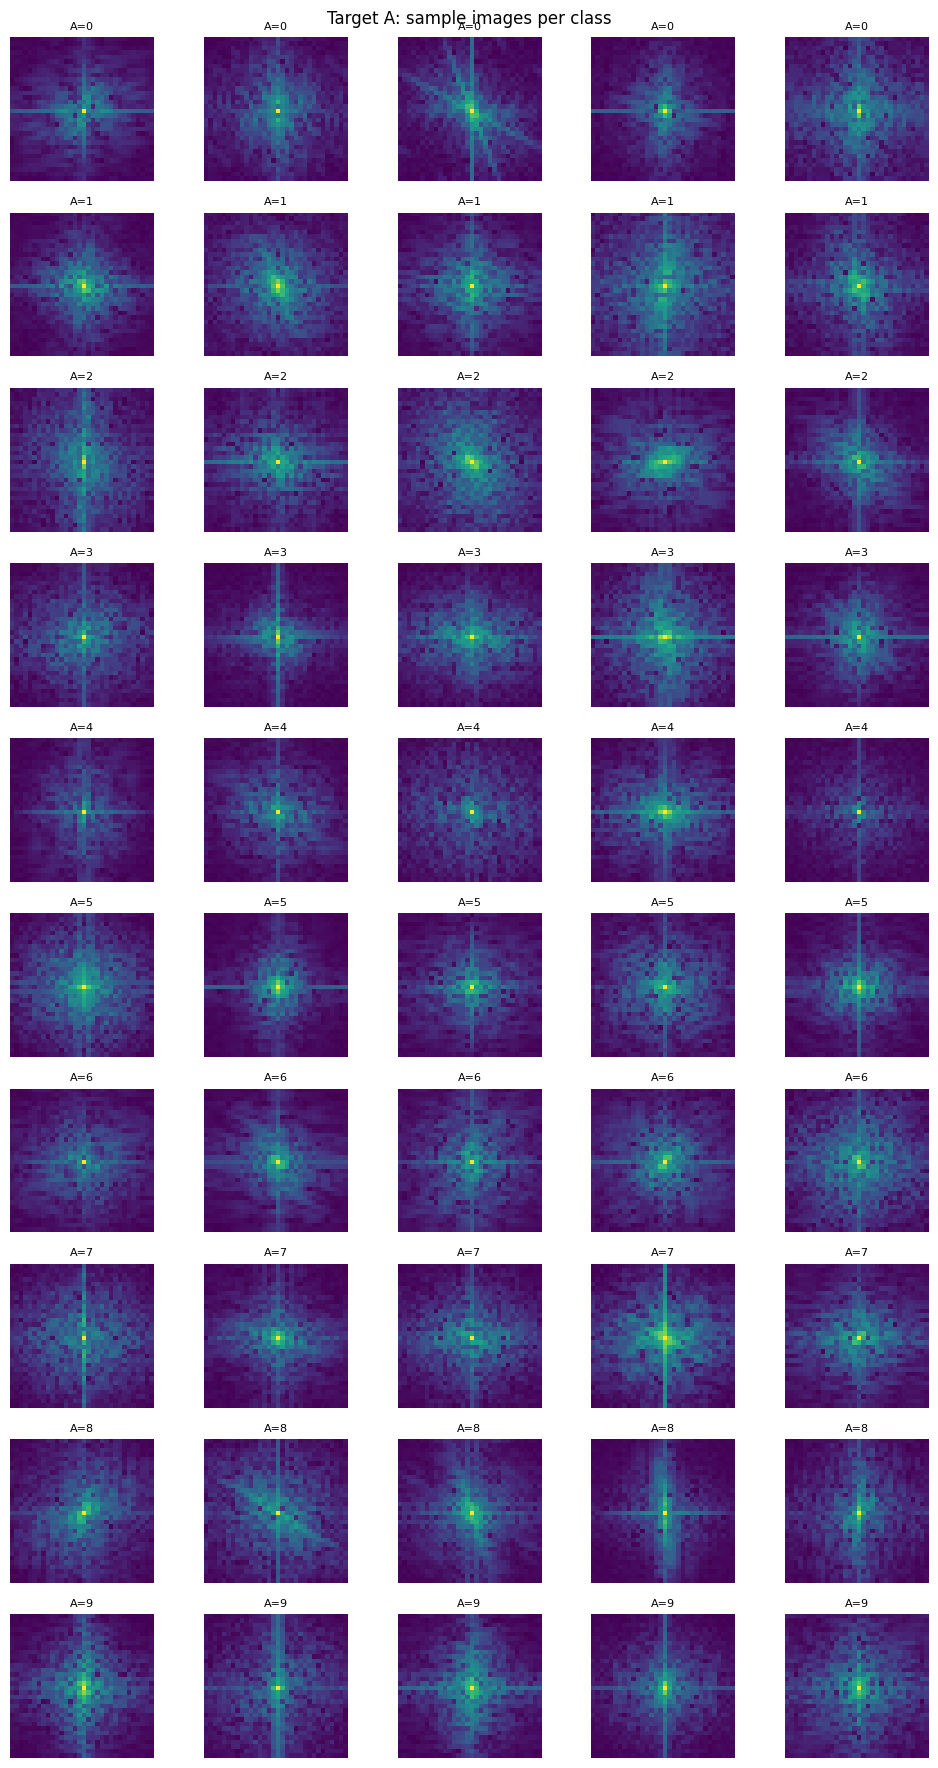

In [29]:
print("--- 3.1 VISUALISE SAMPLES - TARGET A ---")
# --------------------------
# Target A: K samples/class
# --------------------------
n_per_class_a = 5
imgs_a = []
titles_a = []

for cls in range(10):
    idx = np.where(yA == cls)[0]
    if len(idx) == 0:
        continue
    pick = rng.choice(idx, size=min(n_per_class_a, len(idx)), replace=False)
    for j in pick:
        imgs_a.append(X_raw[j])
        titles_a.append(f"A={cls}")

plot_grid(
    imgs_a,
    titles=titles_a,
    nrows=10,
    ncols=n_per_class_a,
    figsize=(2.0 * n_per_class_a, 18),
    suptitle="Target A: sample images per class",
)

--- 3.1 VISUALISE SAMPLES - TARGET B ---


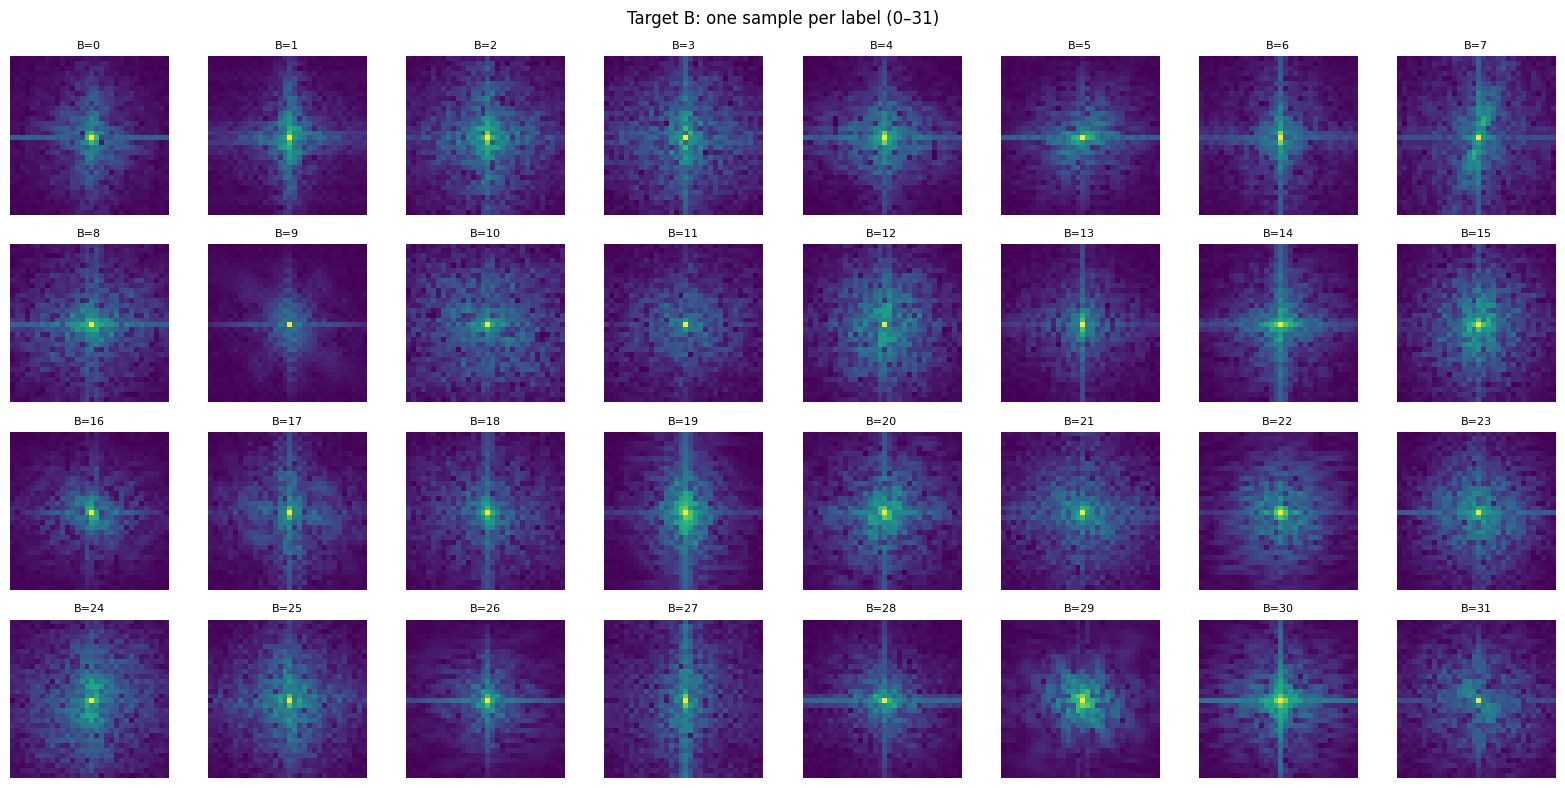

In [30]:
print("--- 3.1 VISUALISE SAMPLES - TARGET B ---")
# --------------------------
# Target B: 1 sample/label
# --------------------------
imgs_b = []
titles_b = []

for cls in range(32):
    idx = np.where(yB == cls)[0]
    if len(idx) == 0:
        imgs_b.append(np.zeros((32, 32), dtype=np.float32))
        titles_b.append(f"B={cls} (missing)")
        continue
    j = rng.choice(idx, size=1, replace=False)[0]
    imgs_b.append(X_raw[j])
    titles_b.append(f"B={cls}")

plot_grid(
    imgs_b,
    titles=titles_b,
    nrows=4,
    ncols=8,
    figsize=(16, 8),
    suptitle="Target B: one sample per label (0–31)",
)

--- 3.1 VISUALISE SAMPLES - TARGET C ---


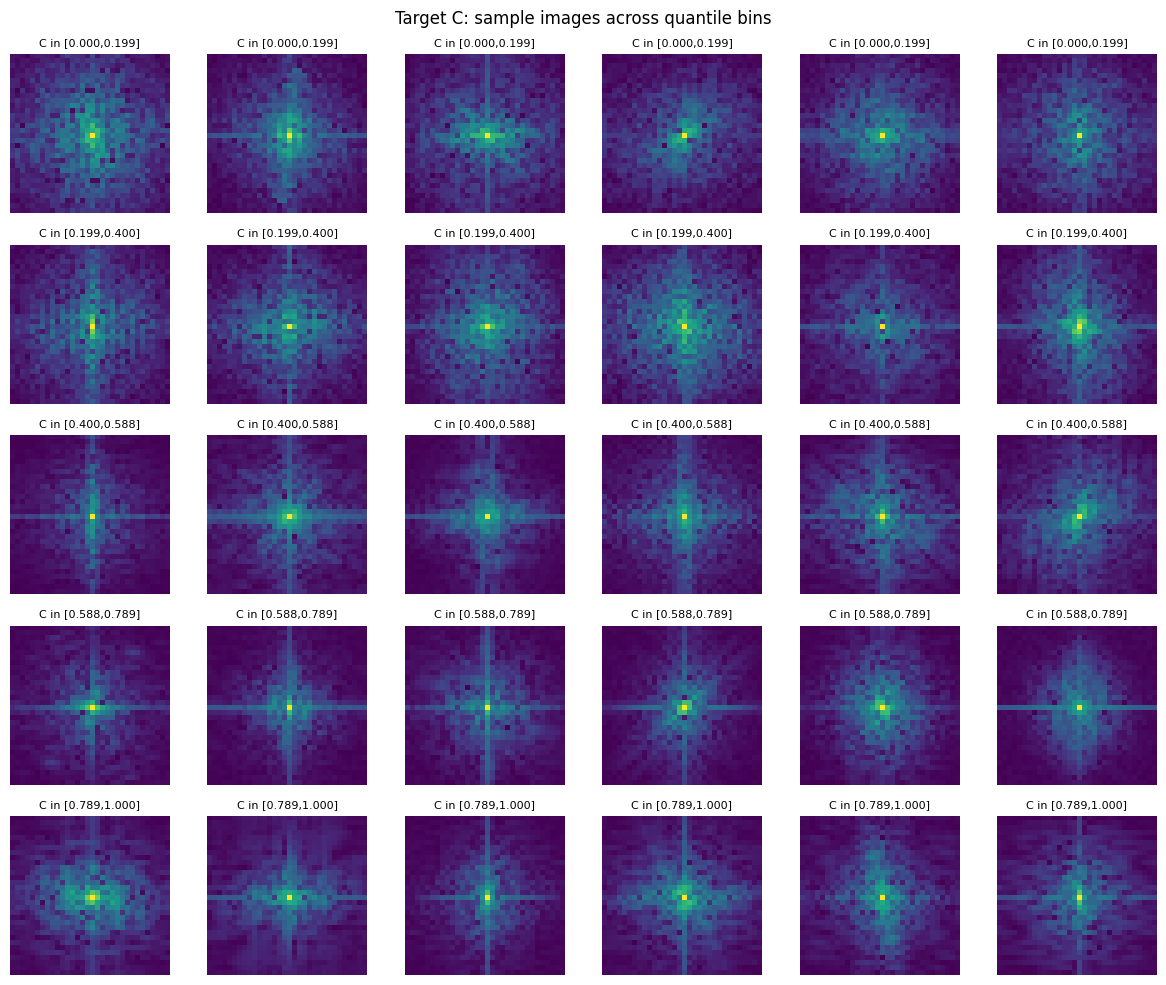

In [31]:
print("--- 3.1 VISUALISE SAMPLES - TARGET C ---")
# --------------------------
# Target C: quantile bins
# --------------------------
q_edges = np.quantile(yC, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bin_id = np.digitize(yC, q_edges[1:-1], right=True)  # 0..4

imgs_c = []
titles_c = []
n_per_bin = 6

for b in range(5):
    idx = np.where(bin_id == b)[0]
    if len(idx) == 0:
        continue
    pick = rng.choice(idx, size=min(n_per_bin, len(idx)), replace=False)
    lo, hi = q_edges[b], q_edges[b + 1]
    for j in pick:
        imgs_c.append(X_raw[j])
        titles_c.append(f"C in [{lo:.3f},{hi:.3f}]")

plot_grid(
    imgs_c,
    titles=titles_c,
    nrows=5,
    ncols=n_per_bin,
    figsize=(2.0 * n_per_bin, 10),
    suptitle="Target C: sample images across quantile bins",
)

### Discussion

- **Target A**: Samples across the 10 classes exhibit highly similar structure. Most images are dominated by a strong central peak and axis-aligned streaks, with no clearly distinguishable class-specific visual patterns.
- **Target B**: Across the 32 labels, the visual appearance remains largely consistent and dominated by the same shared structure. Any differences appear subtle and inconsistent, suggesting limited separability from direct visual inspection.
- **Target C**: Across quantile bins, the images remain visually similar and dominated by the same shared artifact. No clear monotonic visual trend is observed from low to high Target C values in this qualitative view.

**Reflection**: Overall, the dataset does not present strong label-specific features that are obvious to manual inspection. This suggests that discriminative information (if present) is subtle and must be learned through feature extraction, motivating the use of a sufficiently expressive CNN trunk and careful regularization/preprocessing.


## 2.2 Label imbalance check

### Description

We will quickly check if the dataset is imbalanced:

- **Target A**: class counts (0–9) and imbalance ratio.
- **Target B**: class counts (0–31) and imbalance ratio.
- **Target C**: distribution summary (histogram + percentiles). _(Not “imbalance” per se, but we check if it is skewed or concentrated.)_

This informs whether we need class weighting, focal loss, sampling strategies, or special metrics.


--- 3.2 LABEL IMBALANCE CHECK ---
Target A counts: [290 304 311 305 306 294 290 291 310 299]
Target A imbalance ratio (max/min nonzero): 1.0724137931034483


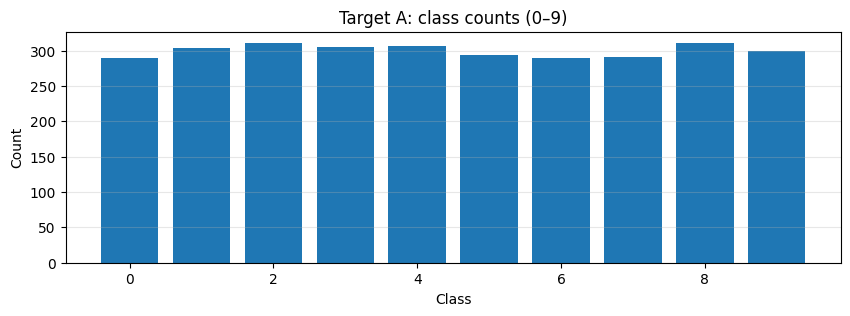

Target B counts: [ 97  99  80 113  89  97  75  94  99  87  85  90 101 101  83  84 106 105
 102  96  93  84  95 104  95  86  89  97 100  88  98  88]
Target B imbalance ratio (max/min nonzero): 1.5066666666666666


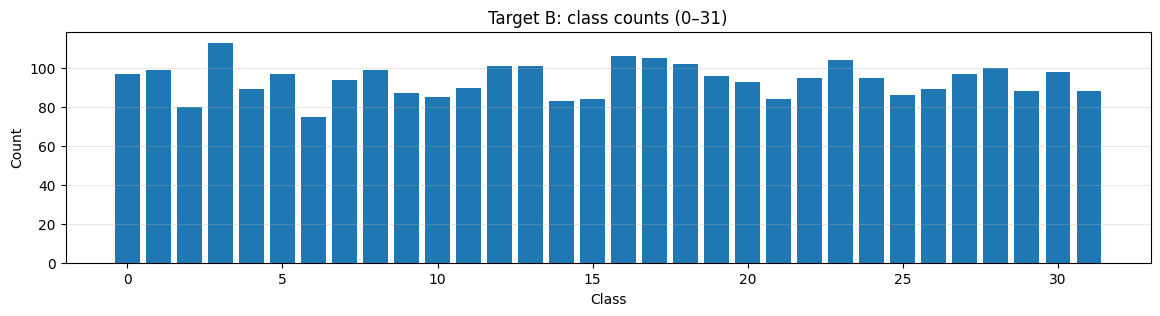

Target C percentiles [0,1,5,25,50,75,95,99,100]: [3.000e-04 6.600e-03 4.210e-02 2.524e-01 4.984e-01 7.361e-01 9.501e-01
 9.898e-01 9.996e-01]


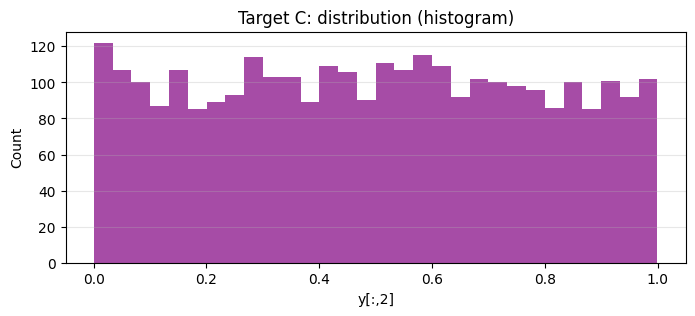

In [32]:
# ==========================================
# 3.2. LABEL IMBALANCE CHECK
# ==========================================

print("--- 3.2 LABEL IMBALANCE CHECK ---")

# Target A
counts_a = np.bincount(yA, minlength=10)
print("Target A counts:", counts_a)
print(
    "Target A imbalance ratio (max/min nonzero):",
    counts_a.max() / counts_a[counts_a > 0].min(),
)

plt.figure(figsize=(10, 3))
plt.bar(np.arange(10), counts_a)
plt.title("Target A: class counts (0–9)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Target B
counts_b = np.bincount(yB, minlength=32)
print("Target B counts:", counts_b)
print(
    "Target B imbalance ratio (max/min nonzero):",
    counts_b.max() / counts_b[counts_b > 0].min(),
)

plt.figure(figsize=(14, 3))
plt.bar(np.arange(32), counts_b)
plt.title("Target B: class counts (0–31)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Target C
pct = np.percentile(yC, [0, 1, 5, 25, 50, 75, 95, 99, 100])
print("Target C percentiles [0,1,5,25,50,75,95,99,100]:", np.round(pct, 4))

plt.figure(figsize=(8, 3))
plt.hist(yC, bins=30, color="purple", alpha=0.7)
plt.title("Target C: distribution (histogram)")
plt.xlabel("y[:,2]")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

### Discussion

- **Target A**: The label distribution is highly uniform across the 10 classes. Counts range from 290 to 311, yielding a low imbalance ratio (max/min nonzero) of **1.0724**. This suggests class imbalance is unlikely to be a major driver of performance differences for Target A.

- **Target B**: The 32-class distribution is also relatively even. Counts range from 75 to 113, with an imbalance ratio (max/min nonzero) of **1.5067**. A few classes are approximately **15% below the average** frequency, but there are no extreme rare or missing classes.

- **Target C**: The regression target is broadly well-distributed across \([0, 1]\). The median is approximately **0.4984** and the interquartile range spans roughly **0.2524 to 0.7361**. The tails are present but not excessively concentrated (95th percentile ≈ **0.9501**, 99th percentile ≈ **0.9898**), indicating no strong skew toward a narrow range.

**Reflection**: Since Targets A and B are close to uniformly distributed and Target C is not strongly skewed, imbalance is unlikely to be the primary bottleneck. If a target has a low performance, it is more likely due to limited separable signal or task difficulty rather than label frequency.